In [17]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_json_to_s3

In [19]:
# Load latest player stats from S3
df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
df2 = load_dataframe_from_s3('data/advanced_player_stats/2024-2025.parquet')
df3 = load_dataframe_from_s3('data/advanced_player_stats/2023-2024.parquet')
df4 = load_dataframe_from_s3('data/advanced_player_stats/2022-2023.parquet')
df = pd.concat([df, df2, df3, df4], ignore_index = True)

# Set player as index and filter for meaningful playing time
df.set_index('PLAYER', inplace=True)
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 12]

# Drop columns we don't want to use for clustering
df = df.drop(columns=['id', 'PLAYER_ID', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK', 'STAT_TYPE', 'SCRAPED_DATE', "SOURCE"])

df.head()

,AGE,MIN,OFFRTG,DEF_RTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT_TEAM,...,FG3M_UAST_PERCENT,FGM_AST_PERCENT,FGM_UAST_PERCENT,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
a.j. lawson,24.0,18.7,109.7,111.1,-1.4,0.093,2.07,11.7,0.036,0.128,...,0.061,0.763,0.238,0.153,0.154,6.8,6.5,7.0,20.0,0.064
aj green,25.0,22.7,114.0,107.6,6.4,0.086,2.70,18.6,0.011,0.087,...,0.058,0.912,0.088,0.141,0.048,7.5,5.9,6.6,21.6,0.100
aj johnson,20.0,22.0,104.1,115.6,-11.5,0.178,2.17,22.3,0.011,0.073,...,0.333,0.573,0.427,0.132,0.049,8.3,8.2,8.3,23.8,0.045
aaron gordon,29.0,28.4,122.5,113.0,9.5,0.143,2.25,20.1,0.060,0.109,...,0.133,0.652,0.348,0.096,0.121,10.9,8.0,9.3,30.6,0.080
aaron holiday,28.0,12.8,110.3,103.6,6.7,0.142,2.24,20.5,0.015,0.073,...,0.181,0.650,0.350,0.141,0.120,4.6,3.8,3.6,12.8,0.074


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [20]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEF_RTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FG3M_UAST_PERCENT,FGM_AST_PERCENT,FGM_UAST_PERCENT,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,a.j. lawson,24.0,18.7,109.7,111.1,-1.4,0.093,2.07,11.7,0.036,...,0.061,0.763,0.238,0.153,0.154,6.8,6.5,7.0,20.0,0.064
1,aj green,25.0,22.7,114.0,107.6,6.4,0.086,2.70,18.6,0.011,...,0.058,0.912,0.088,0.141,0.048,7.5,5.9,6.6,21.6,0.100
2,aj johnson,20.0,22.0,104.1,115.6,-11.5,0.178,2.17,22.3,0.011,...,0.333,0.573,0.427,0.132,0.049,8.3,8.2,8.3,23.8,0.045
3,aaron gordon,29.0,28.4,122.5,113.0,9.5,0.143,2.25,20.1,0.060,...,0.133,0.652,0.348,0.096,0.121,10.9,8.0,9.3,30.6,0.080
4,aaron holiday,28.0,12.8,110.3,103.6,6.7,0.142,2.24,20.5,0.015,...,0.181,0.650,0.350,0.141,0.120,4.6,3.8,3.6,12.8,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,zach collins,25.0,22.9,108.7,116.3,-7.5,0.180,1.40,19.6,0.076,...,0.000,0.662,0.338,0.189,0.480,9.0,7.4,7.1,27.0,0.046
1163,zach lavine,28.0,35.9,112.0,111.7,0.3,0.187,1.69,15.7,0.016,...,0.353,0.429,0.571,0.163,0.073,11.5,8.5,9.7,35.2,0.118
1164,zeke nnaji,22.0,13.7,101.5,107.4,-5.9,0.040,0.58,6.6,0.087,...,0.000,0.764,0.236,0.143,0.295,5.2,3.8,3.7,14.9,0.062
1165,ziaire williams,21.0,15.2,106.9,112.2,-5.2,0.086,0.95,12.6,0.028,...,0.120,0.810,0.190,0.156,0.092,5.2,5.1,4.5,14.8,0.048


In [21]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [22]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4491422188974017
Variance with 3 components: 0.5662066145336417
Variance with 4 components: 0.6465391858033122
Variance with 5 components: 0.6951439661031241
Variance with 6 components: 0.7367807224879008
Variance with 7 components: 0.7704147176381235
Variance with 8 components: 0.799777275591447
Variance with 9 components: 0.8266368771488416
Variance with 10 components: 0.849065878411266
Variance with 11 components: 0.869042546980434
Variance with 12 components: 0.8878858911655828
Variance with 13 components: 0.9051357767974516
Variance with 14 components: 0.9206089323052217
Variance with 15 components: 0.93490400400271
Variance with 16 components: 0.9465866536076044
Variance with 17 components: 0.9571582908920134
Variance with 18 components: 0.9659437922523485
Variance with 19 components: 0.9741741541612925
Variance with 20 components: 0.9806882524418803
Variance with 21 components: 0.9852921423574986
Variance with 22 components: 0.9888078097572646
Varia

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

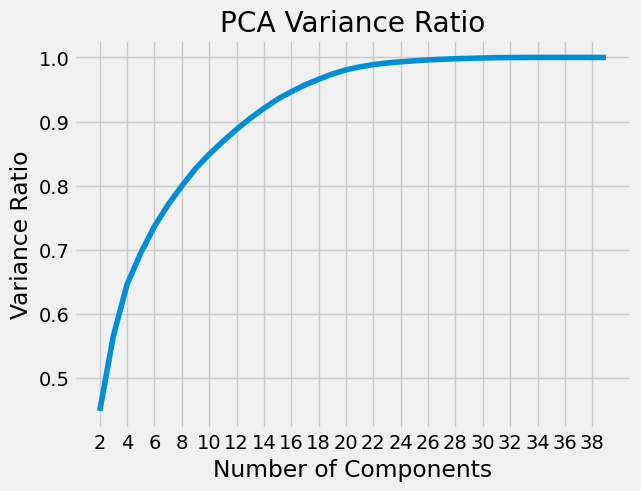

In [23]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [24]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.17064396e-01 8.03325713e-02 4.86047803e-02 4.16367564e-02
 3.36339952e-02 2.93625580e-02 2.68596016e-02 2.24290013e-02
 1.99766686e-02 1.88433442e-02 1.72498856e-02 1.54731555e-02
 1.42950717e-02 1.16826496e-02 1.05716373e-02 8.78550136e-03
 8.23036191e-03 6.51409828e-03 4.60388992e-03 3.51566740e-03
 2.61615714e-03 1.74820232e-03 1.63790316e-03 1.35465271e-03
 9.77757424e-04 8.54806778e-04 6.11737267e-04 5.80110482e-04
 4.64348926e-04 2.02068628e-04 1.28613501e-04 1.49349312e-05
 7.91335481e-07 9.93633943e-08 4.32603031e-09 1.95111149e-09
 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

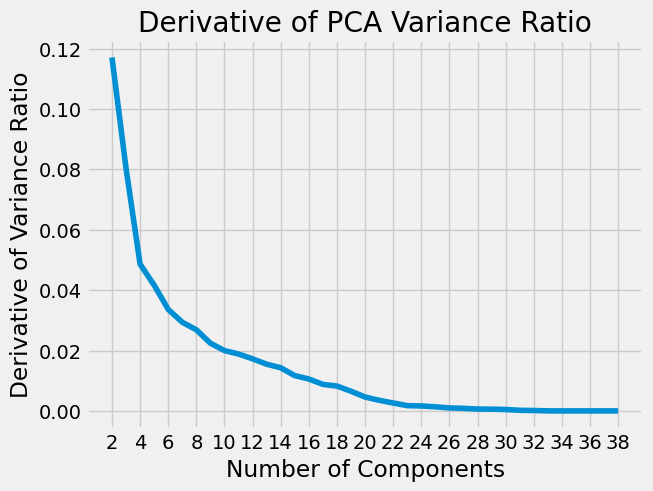

In [25]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [26]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.23655517 0.21258705 0.1170644  0.08033257 0.04860478 0.04163676
 0.033634   0.02936256 0.0268596  0.022429   0.01997667 0.01884334
 0.01724989 0.01547316 0.01429507 0.01168265]
0.9465866536076044


In [27]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}\n")

Silhouette Score with 2 clusters: 0.1674983968348735

Silhouette Score with 3 clusters: 0.2011468381145032

Silhouette Score with 4 clusters: 0.1709579543017735

Silhouette Score with 5 clusters: 0.15097673861555533

Silhouette Score with 6 clusters: 0.14225846740357082

Silhouette Score with 7 clusters: 0.1390366154622972

Silhouette Score with 8 clusters: 0.12185464400582155

Silhouette Score with 9 clusters: 0.11538378133680542

Silhouette Score with 10 clusters: 0.1088315064055059

Silhouette Score with 11 clusters: 0.10944066107152182

Silhouette Score with 12 clusters: 0.10614994223865193

Silhouette Score with 13 clusters: 0.10775103572967554

Silhouette Score with 14 clusters: 0.10517551621696694

Silhouette Score with 15 clusters: 0.10215314545667713

Silhouette Score with 16 clusters: 0.09606875357418566

Silhouette Score with 17 clusters: 0.09696142295997388

Silhouette Score with 18 clusters: 0.09503265781171683

Silhouette Score with 19 clusters: 0.08981648283071574

Silho

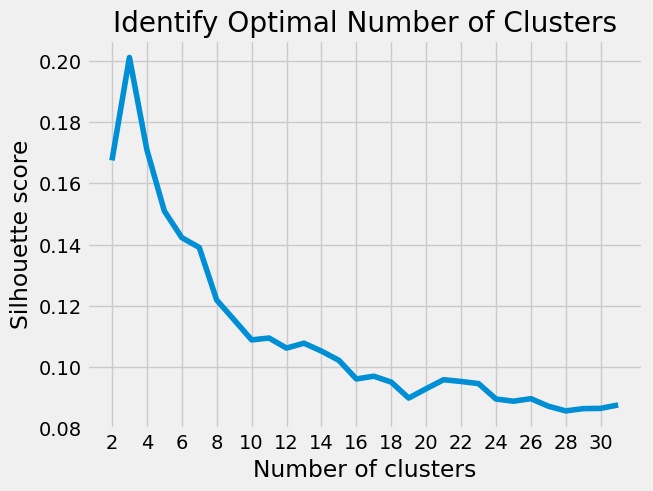

In [28]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [29]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluster = {i + 2}, improvement = {improvement}") 

for n_cluster = 3, improvement = 0.040418470248826055
for n_cluster = 4, improvement = -0.03779027893120701
for n_cluster = 5, improvement = -0.024101570951555074
for n_cluster = 6, improvement = -0.010268589340848289
for n_cluster = 7, improvement = -0.0037562037266878345
for n_cluster = 8, improvement = -0.01995668081250801
for n_cluster = 9, improvement = -0.0073687831118691705
for n_cluster = 10, improvement = -0.007406912504047458
for n_cluster = 11, improvement = 0.0006835460077352362
for n_cluster = 12, improvement = -0.0036951146195707274
for n_cluster = 13, improvement = 0.0017912327432563213
for n_cluster = 14, improvement = -0.002886548055356819
for n_cluster = 15, improvement = -0.0033776129454039516
for n_cluster = 16, improvement = -0.006776647767604116
for n_cluster = 17, improvement = 0.0009875412420113916
for n_cluster = 18, improvement = -0.002135861299058961
for n_cluster = 19, improvement = -0.005763937258098206
for n_cluster = 20, improvement = 0.00335175475388505


C:\conda_tmp\ipykernel_10944\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


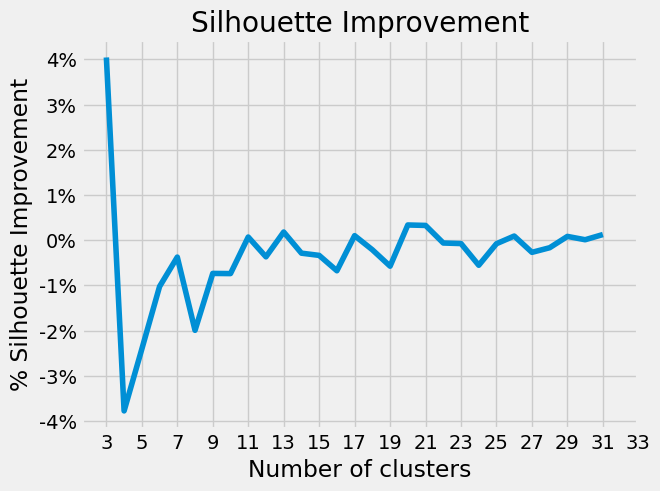

In [30]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [31]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
# with open("../models/clusterMode.sav", 'wb') as f:
#     pickle.dump(kmeans, f)

In [32]:
# Create and save cluster assignments
df_cluster = pd.DataFrame({
    'PLAYER': dfPlayerCol['PLAYER'],
    'CLUSTER': y_kmeans,
    'TIMESTAMP': pd.Timestamp.now()
})

# Save only current version to S3
save_dataframe_to_s3(df_cluster, 'data/clustered_players/current.parquet')

print("\nClustering Summary:")
print(f"Total Players: {len(df_cluster)}")
print(f"Number of Clusters: {len(np.unique(y_kmeans))}")
print(f"Silhouette Score: {silhouette_score(x, y_kmeans):.3f}")

df_cluster.head()

Saved 1167 records to s3://nba-prediction-ibracken/data/clustered_players/current.parquet

Clustering Summary:
Total Players: 1167
Number of Clusters: 15
Silhouette Score: 0.102


,PLAYER,CLUSTER,TIMESTAMP
0,a.j. lawson,4,2025-09-06 17:29:47.473371
1,aj green,14,2025-09-06 17:29:47.473371
2,aj johnson,8,2025-09-06 17:29:47.473371
3,aaron gordon,5,2025-09-06 17:29:47.473371
4,aaron holiday,0,2025-09-06 17:29:47.473371


In [33]:
# Print summary of clusters
cluster_counts = df_cluster['CLUSTER'].value_counts().sort_index()
print("\nPlayers per cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} players")


Players per cluster:
Cluster 0: 77 players
Cluster 1: 43 players
Cluster 2: 61 players
Cluster 3: 72 players
Cluster 4: 87 players
Cluster 5: 124 players
Cluster 6: 89 players
Cluster 7: 39 players
Cluster 8: 47 players
Cluster 9: 106 players
Cluster 10: 98 players
Cluster 11: 81 players
Cluster 12: 60 players
Cluster 13: 83 players
Cluster 14: 100 players
